# Classificazione dei coralli usando metodi supervisionati e non supervisionati

L'obiettivo di questo progetto è di classificare immagini di coralli in base alle loro caratteristiche utilizzando sia metodi supervisionati che non supervisionati per poi confrontare le prestazioni dei due approcci.

## Introduzione

I coralli sono organismi che vivono in mare e sono molto importanti per la biodiversità e la salute del mare. Avere un sistema per classificare i coralli in base alle loro caratteristiche è molto utile per velocizzare il processo degli specialisti degli oceani, soprattutto se utilizzassimo un modello non supervisionato che eviterebbe il processo di etichettare ogni immagine dei coralli.

# Imports

In [48]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.feature import local_binary_pattern
from mahotas.features import haralick
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

## Estrazione delle feature

In questa sezione trasformiamo le immagini da RGB a livelli di grigio per poi utilizzare l'algoritmo `Gray-Level Co-occurence Matrix` (GLCM) per estrarre le texture feature e memorizzarle in un dataframe.

In [27]:
train_folder = "REEF_DATASET/EILAT/"
features_list = []         # Lista per le feature
ground_truth_labels_list = [] # lista per le etichette di ground truth

valid_image_extensions = ('.jpg')
# Loop through i numeri delle directory (gli interi da 1 a 8)
for directory_label in range(1, 9):
    sub_folder_name_only = f"A0{directory_label}" 
    current_sub_folder_path = os.path.join(train_folder, sub_folder_name_only)

    if not os.path.isdir(current_sub_folder_path):
        print(f"Warning: Directory {current_sub_folder_path} not found. Skipping.")
        continue

    try:
        image_filenames_in_dir = [
            f for f in os.listdir(current_sub_folder_path)
            if os.path.isfile(os.path.join(current_sub_folder_path, f)) and \
               f.lower().endswith(valid_image_extensions)
        ]
    except OSError as e:
        print(f"Error: Could not list files in directory {current_sub_folder_path}: {e}. Skipping.")
        continue
        
    if not image_filenames_in_dir:
        print(f"Warning: No valid image files found in {current_sub_folder_path}. Skipping.")
        continue

    for image_filename in tqdm(image_filenames_in_dir, desc=f"Processing {sub_folder_name_only}"):
        image_path = os.path.join(current_sub_folder_path, image_filename)

        image = cv2.imread(image_path) 

        if image is None:
            print(f"Warning: Failed to load image {image_path}. Skipping.")
            continue

        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # LOCAL BINARY PATTERNS
        radius = 2
        n_points = 8 * radius
        lbp_image = local_binary_pattern(image_gray, n_points, radius, method='uniform')
        
        n_bins = int(lbp_image.max() + 1)
        lbp_hist, _ = np.histogram(lbp_image.ravel(), density=True, bins=n_bins, range=(0, n_bins))

        # HARALICK FEATURES
        haralick_features_matrix = haralick(image_gray) 
        b = haralick_features_matrix.mean(axis=0) 
        
        current_features = {
            'lbp_hist': lbp_hist.tolist(),
            'haralick': b.tolist(),
        }

        features_list.append(current_features)
        ground_truth_labels_list.append(directory_label)

df = pd.DataFrame(features_list)
true_labels = np.array(ground_truth_labels_list) - 1 

print(f"DataFrame creato con {len(df)} campioni.")
print(f"Array di ground truth 'true_labels' creato con {len(true_labels)} etichette.")


Processing A08: 100%|██████████| 77/77 [00:00<00:00, 211.43it/s]

DataFrame creato con 1123 campioni.
Array di ground truth 'true_labels' creato con 1123 etichette.


In [28]:
df

,lbp_hist,haralick
0,"[0.094482421875, 0.052734375, 0.04248046875, 0...","[0.001112548267838469, 134.17850351946333, 0.5..."
1,"[0.091552734375, 0.04150390625, 0.0419921875, ...","[0.0006610736677567364, 112.92101678634413, 0...."
2,"[0.093994140625, 0.0537109375, 0.043701171875,...","[0.0014958984489034858, 96.74236662257493, 0.5..."
3,"[0.114990234375, 0.0537109375, 0.036865234375,...","[0.00035153062099511326, 263.91843919280666, 0..."
4,"[0.0869140625, 0.046875, 0.043212890625, 0.037...","[0.0009869730765262707, 112.9504814657344, 0.7..."
...,...,...
1118,"[0.0556640625, 0.0322265625, 0.035888671875, 0...","[0.0005286024960256381, 126.9292662666918, 0.9..."
1119,"[0.07470703125, 0.038818359375, 0.044189453125...","[0.0003552699896083975, 369.6750047241117, 0.8..."
1120,"[0.06396484375, 0.03369140625, 0.038330078125,...","[0.00037329185261422395, 320.3060811130007, 0...."
1121,"[0.061767578125, 0.031005859375, 0.04077148437...","[0.0010450532994024553, 51.27440495874274, 0.8..."


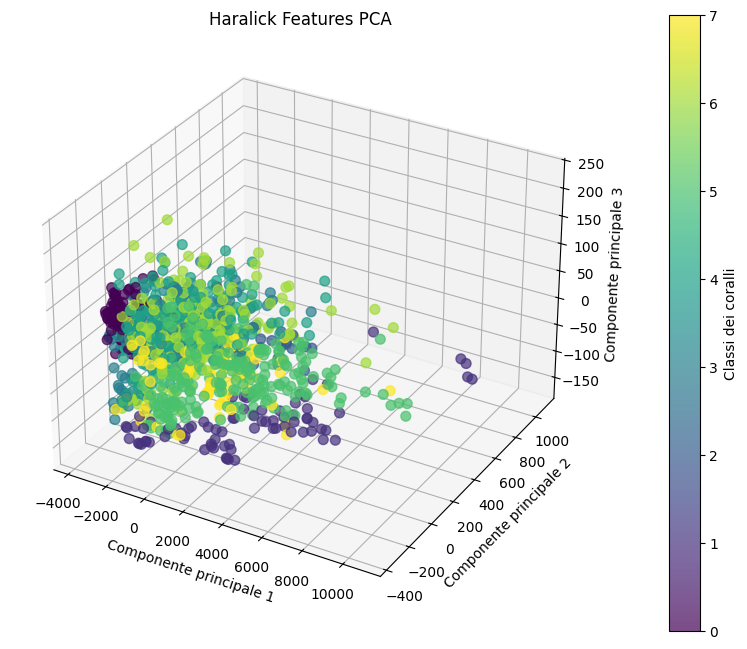

In [96]:
pca_3d = PCA(n_components=3, random_state=42)

haralick_data_for_pca = np.array(df["haralick"].tolist())

X_pca_3d = pca_3d.fit_transform(haralick_data_for_pca)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter_data = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                           s=50, alpha=0.7, c=df['true_labels'], cmap='viridis')

ax.set_title('Haralick Features PCA')
ax.set_xlabel('Componente principale 1')
ax.set_ylabel('Componente principale 2')
ax.set_zlabel('Componente principale 3')

cbar = fig.colorbar(scatter_data, ax=ax, pad=0.1)
cbar.set_label('Classi dei coralli')

plt.show()

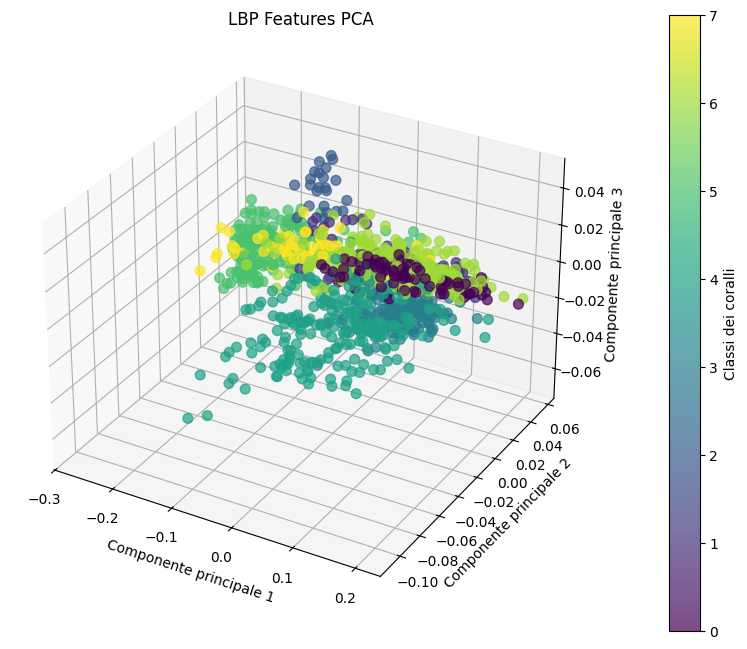

In [94]:
pca_3d = PCA(n_components=3, random_state=42)

lbp_data_for_pca = np.array(df["lbp_hist"].tolist())

X_pca_3d = pca_3d.fit_transform(lbp_data_for_pca)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter_data = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                            s=50, alpha=0.7, c=df['true_labels'], cmap='viridis')

ax.set_title('LBP Features PCA')
ax.set_xlabel('Componente principale 1')
ax.set_ylabel('Componente principale 2')
ax.set_zlabel('Componente principale 3')

cbar = fig.colorbar(scatter_data, ax=ax, pad=0.1)
cbar.set_label('Classi dei coralli')

plt.show()

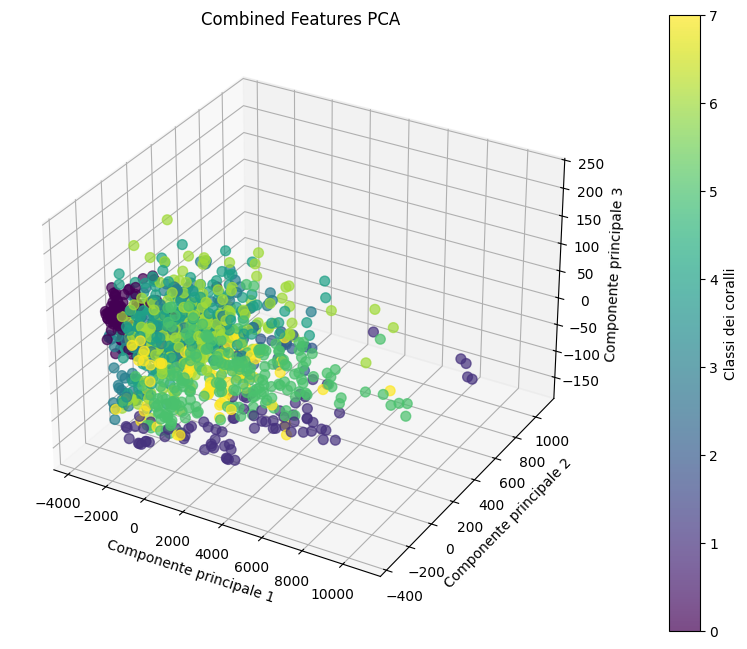

In [92]:
pca_3d = PCA(n_components=3, random_state=42)

combined_features_for_pca = np.concatenate((lbp_data_for_pca, haralick_data_for_pca), axis=1)

X_pca_3d = pca_3d.fit_transform(combined_features_for_pca)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter_data = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                            s=50, alpha=0.7, c=df['true_labels'], cmap='viridis')

ax.set_title('Combined Features PCA')
ax.set_xlabel('Componente principale 1')
ax.set_ylabel('Componente principale 2')
ax.set_zlabel('Componente principale 3')

cbar = fig.colorbar(scatter_data, ax=ax, pad=0.1)
cbar.set_label('Classi dei coralli')

plt.show()

# Supervised Learning

Per quanto riguarda la parte supervisionata utilizzerò un modello di Logistic Regression multi-classe

In [32]:
df['true_labels'] = true_labels
df

,lbp_hist,haralick,true_labels
0,"[0.094482421875, 0.052734375, 0.04248046875, 0...","[0.001112548267838469, 134.17850351946333, 0.5...",0
1,"[0.091552734375, 0.04150390625, 0.0419921875, ...","[0.0006610736677567364, 112.92101678634413, 0....",0
2,"[0.093994140625, 0.0537109375, 0.043701171875,...","[0.0014958984489034858, 96.74236662257493, 0.5...",0
3,"[0.114990234375, 0.0537109375, 0.036865234375,...","[0.00035153062099511326, 263.91843919280666, 0...",0
4,"[0.0869140625, 0.046875, 0.043212890625, 0.037...","[0.0009869730765262707, 112.9504814657344, 0.7...",0
...,...,...,...
1118,"[0.0556640625, 0.0322265625, 0.035888671875, 0...","[0.0005286024960256381, 126.9292662666918, 0.9...",7
1119,"[0.07470703125, 0.038818359375, 0.044189453125...","[0.0003552699896083975, 369.6750047241117, 0.8...",7
1120,"[0.06396484375, 0.03369140625, 0.038330078125,...","[0.00037329185261422395, 320.3060811130007, 0....",7
1121,"[0.061767578125, 0.031005859375, 0.04077148437...","[0.0010450532994024553, 51.27440495874274, 0.8...",7


Ora che abbiamo il dataframe contenente le features e le etichette di ground truth, possiamo procedere con la sua visualizzazione.

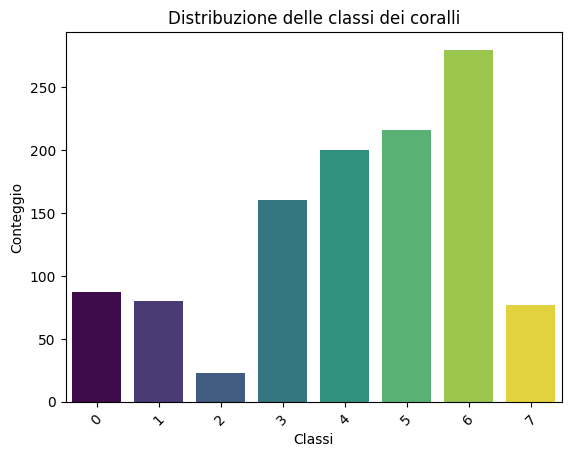

In [81]:
sns.countplot(x='true_labels', data=df, hue='true_labels', palette='viridis', legend=False)
plt.title('Distribuzione delle classi dei coralli')
plt.xlabel('Classi')
plt.ylabel('Conteggio')
plt.xticks(rotation=45)
plt.show()

In [51]:

features_combined = combined_features_for_pca
features_LBP = lbp_data_for_pca
features_haralick = haralick_data_for_pca
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(features_combined, df['true_labels'], test_size=0.2, random_state=42, shuffle=True)
X_train_LBP, X_test_LBP, y_train_LBP, y_test_LBP = train_test_split(features_LBP, df['true_labels'], test_size=0.2, random_state=42, shuffle=True)
X_train_haralick, X_test_haralick, y_train_haralick, y_test_haralick = train_test_split(features_haralick, df['true_labels'], test_size=0.2, random_state=42, shuffle=True)

we can’t forget to scale our data. This is important because it help us to balance the impact of all variables on the distance calculation and can help to improve the performance of the algorithm

In [52]:
st_x = StandardScaler()
X_train_combined = st_x.fit_transform(X_train_combined)
X_test_combined = st_x.transform(X_test_combined)
X_train_LBP = st_x.fit_transform(X_train_LBP)
X_test_LBP = st_x.transform(X_test_LBP)
X_train_haralick = st_x.fit_transform(X_train_haralick)
X_test_haralick = st_x.transform(X_test_haralick)

In [53]:
def logistic_model(C, solver_):
    logistic_regression_model = LogisticRegression(random_state=42, solver=solver_, n_jobs=1, C=C, max_iter=5000)
    return logistic_regression_model

Text(0.5, 1.0, 'Beans Accuracy')

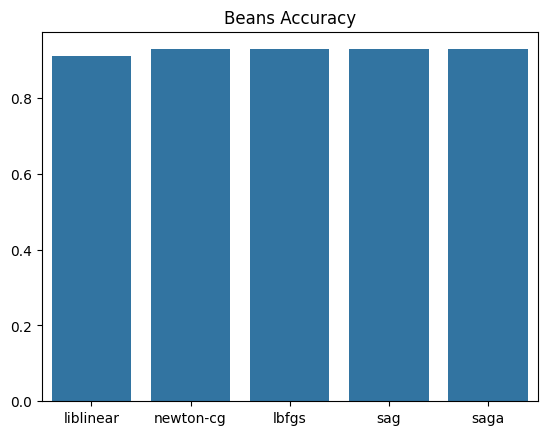

In [71]:
solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
scores = []
params = []

for i in solver_list:
        try:
            model = logistic_model(10, i)
            model.fit(X_train_combined, y_train_combined)
            predictions = model.predict(X_test_combined)
            params.append(i)
            accuracy = accuracy_score(y_test_combined, predictions)
            scores.append(accuracy)
        except:
            print(f"Solver {i} ha generato un errore/warning: {e}")


sns.barplot(x=params, y=scores).set_title('Beans Accuracy')


In [72]:
print(f"Numero di classi uniche in y_train: {len(np.unique(y_train_combined))}")
print(f"Classi uniche: {np.unique(y_train_combined)}")

solver_accuracy = []
print("Scores ottenuti:")
for solver_name, score_val in zip(params, scores):
    print(f"  Solver: {solver_name}, Accuracy: {score_val:.6f}")
    solver_accuracy.append((solver_name, score_val))


Numero di classi uniche in y_train: 8
Classi uniche: [0 1 2 3 4 5 6 7]
Scores ottenuti:
  Solver: liblinear, Accuracy: 0.911111
  Solver: newton-cg, Accuracy: 0.928889
  Solver: lbfgs, Accuracy: 0.928889
  Solver: sag, Accuracy: 0.928889
  Solver: saga, Accuracy: 0.928889


Best solver: newton-cg, Accuracy: 0.928889


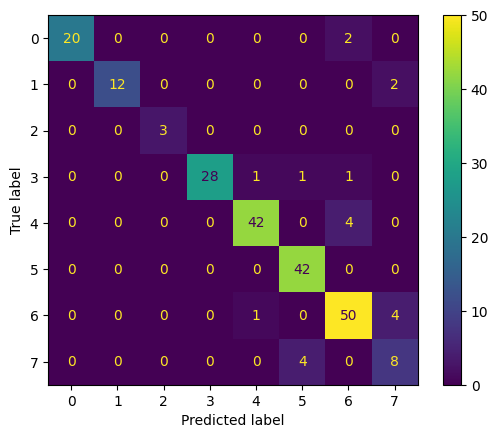

In [65]:
solver = max(solver_accuracy, key=lambda x: x[1])
print(f"Best solver: {solver[0]}, Accuracy: {solver[1]:.6f}")
model = logistic_model(1, solver[0])
model.fit(X_train_combined, y_train_combined)
predictions = model.predict(X_test_combined)

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test_combined, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [40]:
n_lbp_features = lbp_data_for_pca.shape[1] # Number of LBP features
n_haralick_features = haralick_data_for_pca.shape[1] # Number of Haralick features

feature_names_lbp = [f'LBP_{i}' for i in range(n_lbp_features)]
feature_names_haralick = [f'Haralick_{i}' for i in range(n_haralick_features)]
all_feature_names = feature_names_lbp + feature_names_haralick # This is the 'features' list


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        22
           1       1.00      0.86      0.92        14
           2       1.00      1.00      1.00         3
           3       1.00      0.90      0.95        31
           4       0.95      0.91      0.93        46
           5       0.89      1.00      0.94        42
           6       0.88      0.91      0.89        55
           7       0.57      0.67      0.62        12

    accuracy                           0.91       225
   macro avg       0.91      0.89      0.90       225
weighted avg       0.92      0.91      0.91       225



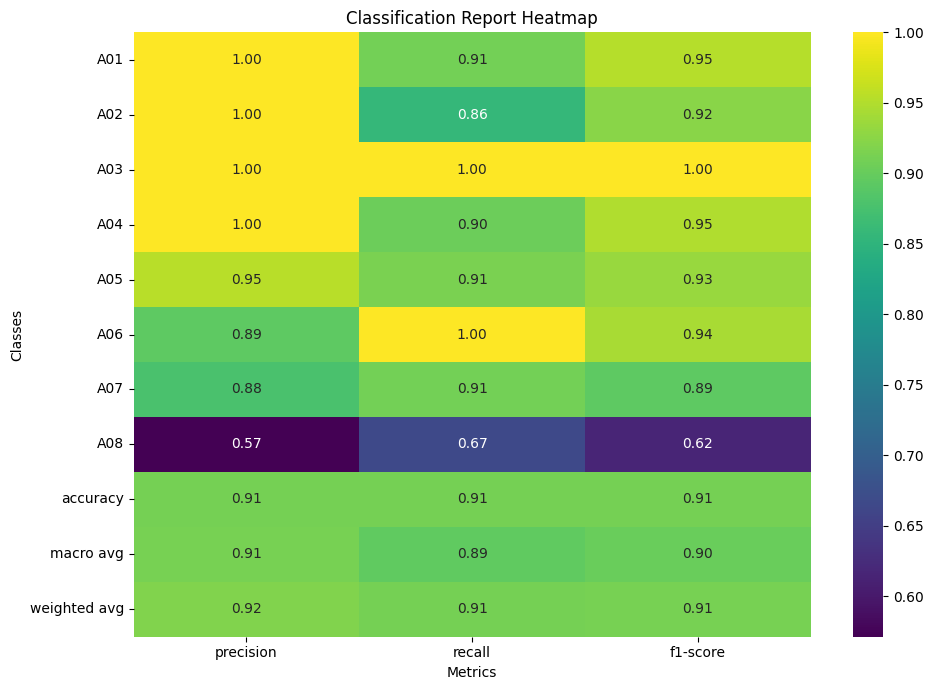

In [41]:
report = classification_report(y_test_combined, predictions)
print("\nClassification Report:")
print(report)

class_labels_for_report = [f"A0{i+1}" for i in sorted(np.unique(y_test_combined))]

report_dict = classification_report(y_test_combined, predictions, output_dict=True, target_names=class_labels_for_report)
report_df = pd.DataFrame(report_dict).iloc[:-1, :].T    

metrics_to_plot = ['precision', 'recall', 'f1-score']
report_df_filtered = report_df[metrics_to_plot]


plt.figure(figsize=(10, 7))
sns.heatmap(report_df_filtered, annot=True, fmt=".2f", cmap="viridis")
plt.title('Classification Report Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.tight_layout()
plt.show()

Best solver: newton-cg, Accuracy: 0.928889


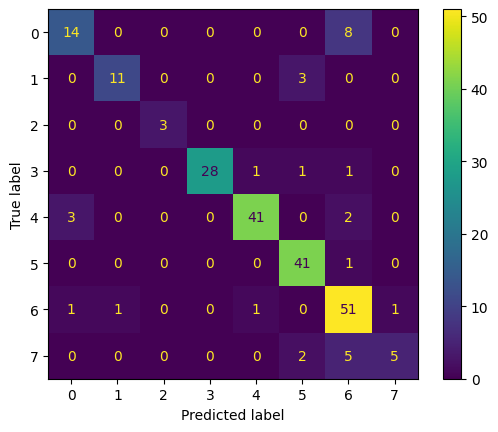

In [42]:
solver = max(solver_accuracy, key=lambda x: x[1])
print(f"Best solver: {solver[0]}, Accuracy: {solver[1]:.6f}")
model = logistic_model(1, solver[0])
model.fit(X_train_LBP, y_train_LBP)
predictions = model.predict(X_test_LBP)

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test_LBP, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        22
           1       0.92      0.79      0.85        14
           2       1.00      1.00      1.00         3
           3       1.00      0.90      0.95        31
           4       0.95      0.89      0.92        46
           5       0.87      0.98      0.92        42
           6       0.75      0.93      0.83        55
           7       0.83      0.42      0.56        12

    accuracy                           0.86       225
   macro avg       0.89      0.82      0.84       225
weighted avg       0.87      0.86      0.86       225



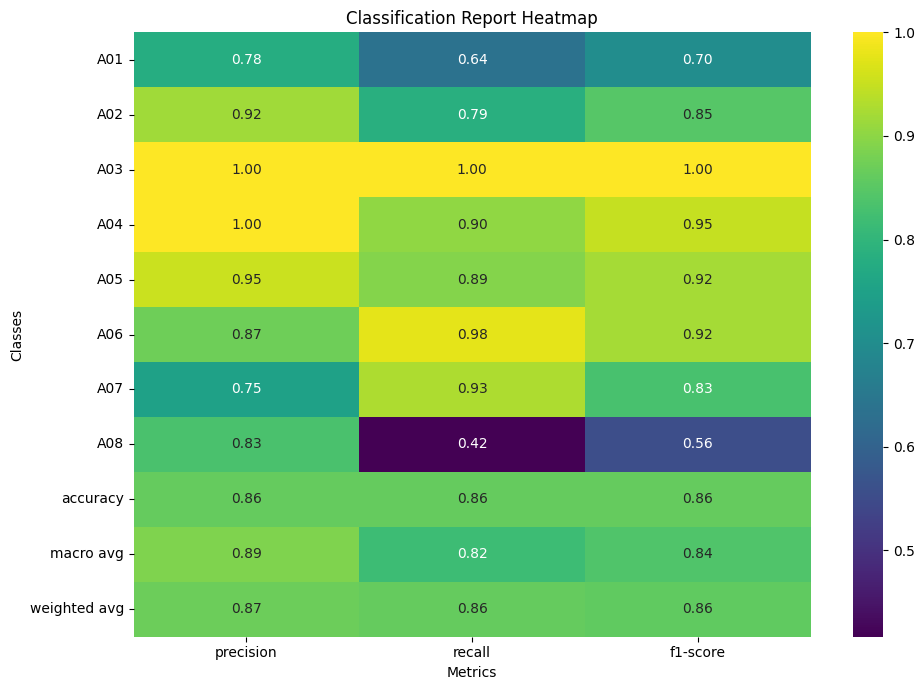

In [43]:
report = classification_report(y_test_LBP, predictions)
print("\nClassification Report:")
print(report)

class_labels_for_report = [f"A0{i+1}" for i in sorted(np.unique(y_test_LBP))]

report_dict = classification_report(y_test_LBP, predictions, output_dict=True, target_names=class_labels_for_report)
report_df = pd.DataFrame(report_dict).iloc[:-1, :].T    

metrics_to_plot = ['precision', 'recall', 'f1-score']
report_df_filtered = report_df[metrics_to_plot]


plt.figure(figsize=(10, 7))
sns.heatmap(report_df_filtered, annot=True, fmt=".2f", cmap="viridis")
plt.title('Classification Report Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.tight_layout()
plt.show()

Best solver: newton-cg, Accuracy: 0.928889


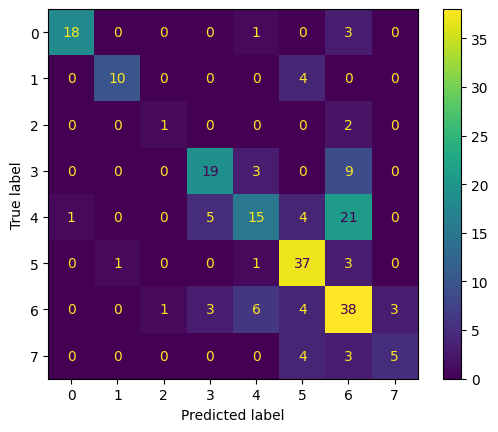

In [44]:
solver = max(solver_accuracy, key=lambda x: x[1])
print(f"Best solver: {solver[0]}, Accuracy: {solver[1]:.6f}")
model = logistic_model(1, solver[0])
model.fit(X_train_haralick, y_train_haralick)
predictions = model.predict(X_test_haralick)

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test_haralick, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.82      0.88        22
           1       0.91      0.71      0.80        14
           2       0.50      0.33      0.40         3
           3       0.70      0.61      0.66        31
           4       0.58      0.33      0.42        46
           5       0.70      0.88      0.78        42
           6       0.48      0.69      0.57        55
           7       0.62      0.42      0.50        12

    accuracy                           0.64       225
   macro avg       0.68      0.60      0.62       225
weighted avg       0.65      0.64      0.63       225



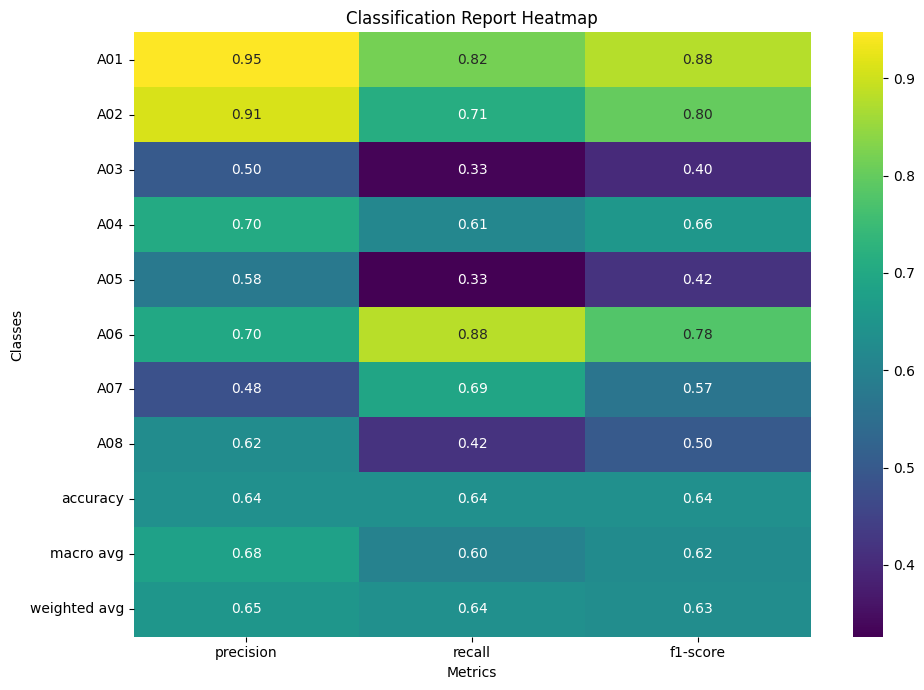

In [45]:
report = classification_report(y_test_haralick, predictions)
print("\nClassification Report:")
print(report)

class_labels_for_report = [f"A0{i+1}" for i in sorted(np.unique(y_test_haralick))]

report_dict = classification_report(y_test_haralick, predictions, output_dict=True, target_names=class_labels_for_report)
report_df = pd.DataFrame(report_dict).iloc[:-1, :].T    

metrics_to_plot = ['precision', 'recall', 'f1-score']
report_df_filtered = report_df[metrics_to_plot]


plt.figure(figsize=(10, 7))
sns.heatmap(report_df_filtered, annot=True, fmt=".2f", cmap="viridis")
plt.title('Classification Report Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.tight_layout()
plt.show()


Il modello ha 8 set di coefficienti (uno per classe vs resto).
Mostrando la magnitudine assoluta media dei coefficienti attraverso le classi:

Feature Importance (Coefficients):
        Feature  Average Absolute Importance
0         LBP_0                     2.023029
8         LBP_8                     1.751410
1         LBP_1                     1.645560
23   Haralick_5                     1.617931
28  Haralick_10                     1.450207
16       LBP_16                     1.401510
7         LBP_7                     1.319553
18   Haralick_0                     1.302695
17       LBP_17                     1.288426
2         LBP_2                     1.270346
9         LBP_9                     1.264994
15       LBP_15                     1.258111
27   Haralick_9                     1.147283
5         LBP_5                     1.135430
6         LBP_6                     1.081397


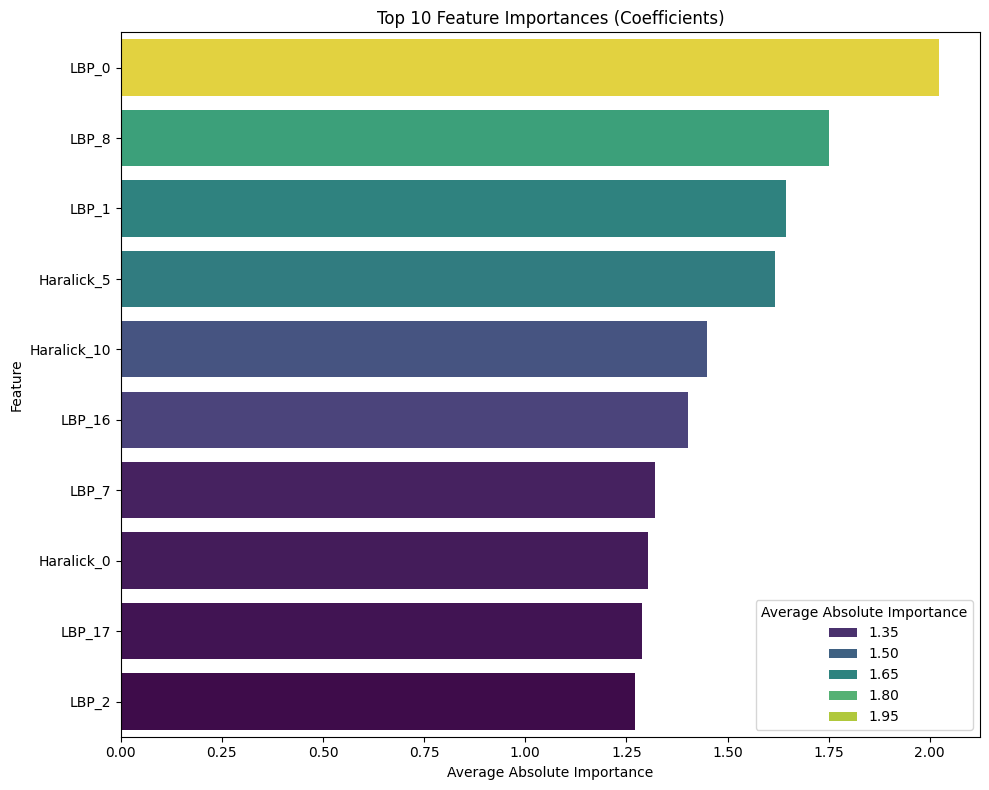

In [ ]:

# Importanza delle Feature
importance_col_name_for_plot = "" 

if hasattr(model, 'coef_'):
    coefficients = model.coef_

    if len(all_feature_names) != coefficients.shape[1]:
        print(f"Error: Mismatch! Number of feature names ({len(all_feature_names)}) "
              f"does not match number of model coefficients ({coefficients.shape[1]}).")
        print("Ensure 'all_feature_names' accurately reflects the features the model was trained on.")
        feature_importance_df = None 
    else:
        if coefficients.shape[0] == 1: 
            feature_importance_values = coefficients[0]
            feature_importance_df = pd.DataFrame({
                'Feature': all_feature_names, 
                'Importance': feature_importance_values
            })
            feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
            importance_col_name_for_plot = 'Importance'
        else: 
            # Multi-class classification 
            print(f"\nIl modello ha {coefficients.shape[0]} set di coefficienti (uno per classe vs resto).")
            print("Mostrando la magnitudine assoluta media dei coefficienti attraverso le classi:")
            
            avg_abs_coeffs = np.mean(np.abs(coefficients), axis=0)
            feature_importance_df = pd.DataFrame({
                'Feature': all_feature_names, 
                'Average Absolute Importance': avg_abs_coeffs
            })
            feature_importance_df = feature_importance_df.sort_values(by='Average Absolute Importance', ascending=False)
            importance_col_name_for_plot = 'Average Absolute Importance'

        if feature_importance_df is not None:
            print("\nFeature Importance (Coefficients):")
            print(feature_importance_df.head(15)) 

            plt.figure(figsize=(10, 8)) 
            top_n_to_display = 10 
            sns.barplot(
                x=importance_col_name_for_plot, 
                y='Feature', 
                data=feature_importance_df.head(top_n_to_display), 
                palette='viridis',
                hue=importance_col_name_for_plot, 
                dodge=False 
            )
            plt.title(f'Top {top_n_to_display} Feature Importances (Coefficients)')
            plt.tight_layout()
            plt.show()

# Modello nullo

Accuracy: 0.2493321460373998


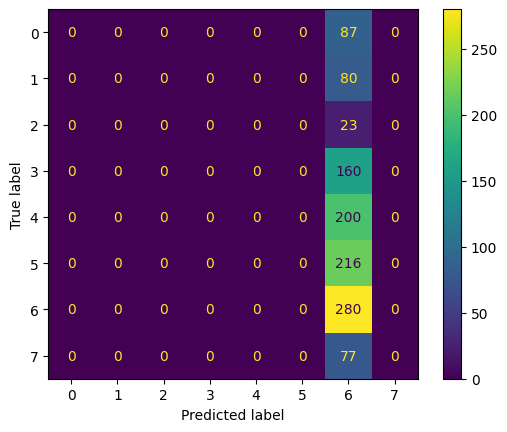

In [49]:

null_model_y = np.full(len(true_labels), 6)
cm = metrics.confusion_matrix(true_labels, null_model_y)
print("Accuracy:", metrics.accuracy_score(true_labels, null_model_y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7])
disp.plot()
plt.show()

## Fonti
- https://github.com/sbianco78/UnsupervisedPlanktonLearning
- LBP: https://scikit-image.org/docs/0.24.x/auto_examples/features_detection/plot_local_binary_pattern.html
- LBP: https://arxiv.org/html/2407.18665v1
- Haralick: https://www.haralick.org/journals/TexturalFeatures.pdf
- PCA: https://www.ibm.com/it-it/think/topics/principal-component-analysis
- Logistic Regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- Logistic Regression: https://danhergir.medium.com/implementing-multi-class-logistic-regression-with-scikit-learn-53d919b72c13